# initialize data for this repository
Eric Gagliano (egagli@uw.edu)   
Updated: February 12th, 2024

**This notebook is not meant to be run by the user, but is meant to document workflow that is used to pull in the SNOTEL and CCSS data and create the CSVs. The auto-update script and github action will keep all station data and the station geojson updated. To reinitialize and start over with a fresh set of data:**
1. remove old data
    - `!rm data/`
    - `!rm all_stations.geojson`
    - `git add` / `git commit` / `!git push` deletions
2. set up snotel_ccss_env for this notebook
    - `!mamba env create -q -f environment.yml --force`
    - `!mamba activate snotel_ccss_env`
    - switch kernels to snotel_ccss_env
3. run this notebook and push updated data
    - run section 1
    - run section 2, and keep re-running until no more stations added
        - there are some stations that there is truly no data for, but often stations will fail and a re-run will bring the data in
        - I usually run ~4 times before no new stations are added
    - run section 3
    - `git add` / `git commit` / `git push` both `data/` folder and `all_stations.geojson`
    - might have to use [git gc](https://git-scm.com/docs/git-gc) to clean repo
4. check automatic workflow
    - make sure github action is working and running daily 
    - check most recently updated CSVs and make sure start and end dates correct

In [ ]:
#!mamba env create -q -f environment.yml --force
#!mamba activate snotel_ccss_env
# switch kernels

## 1. Create separate SNOTEL and CCSS station geodataframes

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
from urllib.parse import urlencode
import matplotlib.pyplot as plt
from datetime import datetime
from io import StringIO
import numpy as np
import mgrs
import datetime
import os
import time
import glob
import ee
ee.Initialize()
import sys
sys.path.append('snotel_ccss_stations')
import snotel_ccss_stations
import shapely
import ulmo
import fsspec
import tqdm

wsdl_url = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

In [2]:
%%time
snotel_stations_gdf = snotel_ccss_stations.all_snotel_stations(from_ulmo=True)

/home/jovyan/snotel_tools/snotel_ccss_stations/snotel_ccss_stations.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stations_df['endDate'] = pd.to_datetime(stations_df.endDate)
/home/jovyan/snotel_tools/snotel_ccss_stations/snotel_ccss_stations.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stations_df['beginDate'] = pd.to_datetime(stations_df.beginDate)
/home/jovyan/snotel_tools/snotel_ccss_stations/snotel_ccss_stations.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
 

CPU times: user 10.9 s, sys: 230 ms, total: 11.1 s
Wall time: 14.8 s


In [3]:
snotel_stations_gdf

,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,HUC,isActive,mgrs,mountainRange,geometry
code,,,,,,,,,,,,,
301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,180200021403,True,10TFL,Great Basin Ranges,POINT (-120.79192 41.23583)
907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,160300020301,True,12SUG,Colorado Plateau,POINT (-112.27118 37.52217)
916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,100200050701,True,12TVR,Central Montana Rocky Mountains,POINT (-111.95902 45.59723)
1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28 00:00:00,2100-01-01,190205051106,True,05VPJ,NaN,POINT (-150.88966 61.74967)
908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,171100100501,True,10TET,Cascade Range,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,150601030802,True,12SWC,Southwest Basins and Ranges,POINT (-110.91773 33.81242)
1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,140600090303,True,12SVJ,Colorado Plateau,POINT (-111.35685 39.13233)
1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,160300060202,True,12SUG,Colorado Plateau,POINT (-112.77495 37.74797)


In [4]:
%%time
ccss_stations_gdf = snotel_ccss_stations.all_ccss_stations()

CPU times: user 14.9 s, sys: 588 ms, total: 15.5 s
Wall time: 2min 4s


In [5]:
ccss_stations_gdf

,name,elevation_m,latitude,longitude,county,state,HUC,mgrs,mountainRange,beginDate,endDate,geometry
code,,,,,,,,,,,,
FRW,Farewell Gap,2895.60,36.415211,-118.578979,Tulare,California,180300070202,11SLA,Sierra Nevada,2004-10-01,2024-02-19,POINT (-118.57898 36.41521)
BNK,Bonanza King,1965.96,41.083118,-122.631271,Trinity,California,180102110304,10TEL,Klamath Mountains,2011-01-03,2024-02-19,POINT (-122.63127 41.08312)
CDP,Cedar Pass,2164.08,41.583000,-120.303000,Modoc,California,180200020603,10TGM,Great Basin Ranges,NaT,NaT,POINT (-120.30300 41.58300)
CRL,Charlotte Lake,3169.92,36.777523,-118.426010,Fresno,California,180300100206,11SLA,Sierra Nevada,2004-10-01,2023-12-11,POINT (-118.42601 36.77752)
CHM,Chilkoot Meadow,2179.32,37.408390,-119.492188,Madera,California,180400061101,11SKB,Sierra Nevada,2006-10-01,2024-02-19,POINT (-119.49219 37.40839)
...,...,...,...,...,...,...,...,...,...,...,...,...
SLT,Slate Creek,1737.36,41.043980,-122.480103,Shasta,California,180200050304,10TEL,Klamath Mountains,2004-10-01,2024-02-12,POINT (-122.48010 41.04398)
SLI,Slide Canyon,2804.16,38.091234,-119.431881,Tuolumne,California,180400090501,11SKC,Sierra Nevada,2005-10-01,2024-02-19,POINT (-119.43188 38.09123)
SLK,South Lake,2926.08,37.175903,-118.562660,Inyo,California,180901020601,11SLB,Sierra Nevada,2004-10-01,2024-02-19,POINT (-118.56266 37.17590)


## 2. Download data for all SNOTEL and CCSS stations (remember to re-run) and then save a compressed file of all CSV data

In [13]:
#snotel_ccss_stations.download_snotel_data_csv(snotel_stations_gdf)

In [12]:
#snotel_ccss_stations.download_ccss_data_csv(ccss_stations_gdf)

In [14]:
#os.system('tar -czvf data/all_station_data.tar.gz data/*.csv')

## 3. Merge SNOTEL and CCSS station geodataframes, add new column "csvData" and set to True if we have data, save final geojson

In [15]:
all_stations_gdf = pd.concat([snotel_stations_gdf,ccss_stations_gdf])
all_stations_gdf
condition = all_stations_gdf.index.str.contains("SNTL")
all_stations_gdf['network'] = np.where(condition,"SNOTEL","CCSS")
all_stations_gdf = all_stations_gdf[['name','network','elevation_m','latitude','longitude','state','HUC','mgrs','mountainRange','beginDate','endDate','geometry']]

In [16]:
all_stations_gdf

,name,network,elevation_m,latitude,longitude,state,HUC,mgrs,mountainRange,beginDate,endDate,geometry
code,,,,,,,,,,,,
301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,41.235828,-120.791924,California,180200021403,10TFL,Great Basin Ranges,1983-10-01,2100-01-01,POINT (-120.79192 41.23583)
907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,37.522171,-112.271179,Utah,160300020301,12SUG,Colorado Plateau,1994-10-01,2100-01-01,POINT (-112.27118 37.52217)
916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,45.597229,-111.959023,Montana,100200050701,12TVR,Central Montana Rocky Mountains,1996-09-01,2100-01-01,POINT (-111.95902 45.59723)
1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,61.749668,-150.889664,Alaska,190205051106,05VPJ,NaN,2014-08-28,2100-01-01,POINT (-150.88966 61.74967)
908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,47.779572,-121.698471,Washington,171100100501,10TET,Cascade Range,1994-09-01,2100-01-01,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...,...,...,...,...,...,...
SLT,Slate Creek,CCSS,1737.360000,41.043980,-122.480103,California,180200050304,10TEL,Klamath Mountains,2004-10-01,2024-02-12,POINT (-122.48010 41.04398)
SLI,Slide Canyon,CCSS,2804.160000,38.091234,-119.431881,California,180400090501,11SKC,Sierra Nevada,2005-10-01,2024-02-19,POINT (-119.43188 38.09123)
SLK,South Lake,CCSS,2926.080000,37.175903,-118.562660,California,180901020601,11SLB,Sierra Nevada,2004-10-01,2024-02-19,POINT (-118.56266 37.17590)


Text(0.5, 1.0, 'stations by network')

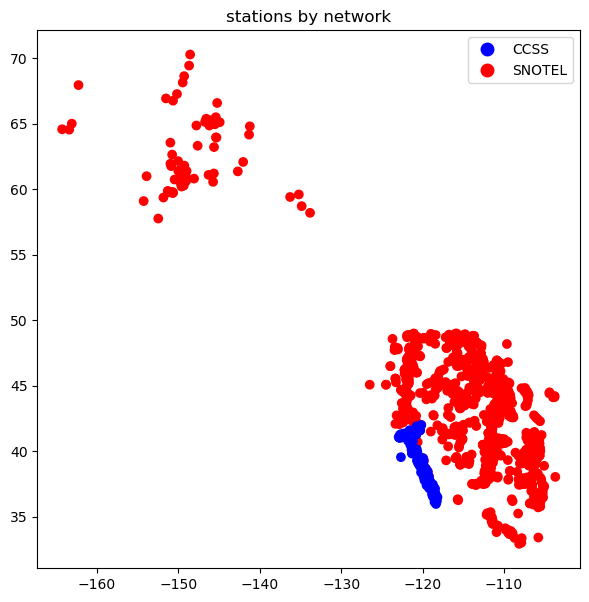

In [17]:
f,ax=plt.subplots(figsize=(7,7))
all_stations_gdf.plot(ax=ax,column='network',cmap='bwr',legend=True)
ax.set_title('stations by network')

In [18]:
current_files = [os.path.splitext(os.path.basename(path))[0] for path in glob.glob('data/*.csv')]
idx_csv = all_stations_gdf.index.isin(current_files)
all_stations_gdf['csvData'] = False
all_stations_gdf.loc[idx_csv,'csvData'] = True

In [19]:
all_stations_gdf = all_stations_gdf[['name','network','elevation_m','latitude','longitude','state','HUC','mgrs','mountainRange','beginDate','endDate','csvData','geometry']]

In [20]:
all_stations_gdf.to_file('all_stations.geojson')